<a href="https://colab.research.google.com/github/kumiori/mec647/blob/Wissam-meshes/practice/withenergy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%%capture
import sys

try:
    import google.colab  # noqa: F401
except ImportError:
    import ufl  # noqa: F401
    import dolfinx  # noqa: F401
else:
    try:
        import ufl
        import dolfinx
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/fenicsx-install.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh";
        import ufl  # noqa: F401
        import dolfinx  # noqa: F401

try:
    import pyvista
except ImportError:
    !{sys.executable} -m pip install --upgrade pyvista itkwidgets;
    import pyvista  # noqa: F401
    from pyvista.utilities import xvfb

try:
    import gmsh
except ImportError:
    !{sys.executable} -m pip install gmsh
    import gmsh

!sudo apt install libgl1-mesa-glx xvfb;
!{sys.executable} -m pip install pythreejs;
!{sys.executable} -m pip install ipygany;
!{sys.executable} -m pip install --upgrade PyYAML
# !pip install --ignore-installed PyYAML


In [11]:
import matplotlib.pyplot as plt
from petsc4py import PETSc
import numpy as np
from mpi4py import MPI
comm = MPI.COMM_WORLD

branch_name = 'Wissam-meshes'
# branch_name = 'main'

!rm -rf mec647
try:
  !git clone -b {branch_name} https://github.com/kumiori/mec647.git
  sys.path.append('mec647/')

  print()
  print(f'Cloned brach: {branch_name}')
  print(f'Last commit message')
  !cd mec647/ && git log -n 1 && cd ..
  import mec647
  from mec647 import meshes
  from mec647.meshes import primitives
  # from mec647.algorithms import am
  from mec647.utils.viz import plot_mesh, plot_scalar, plot_vector

except Exception as e:
  print('Something went wrong', e)
  !rm -rf mec647
  !git clone https://github.com/kumiori/mec647.git



Cloning into 'mec647'...
remote: Enumerating objects: 1060, done.
remote: Counting objects: 100% (1060/1060), done.
remote: Compressing objects: 100% (802/802), done.
remote: Total 1060 (delta 527), reused 533 (delta 229), pack-reused 0
Receiving objects: 100% (1060/1060), 18.67 MiB | 13.40 MiB/s, done.
Resolving deltas: 100% (527/527), done.

Cloned brach: Wissam-meshes
Last commit message
commit b7296df77da0ec2f815e4c84d14936ccdd773cfb (HEAD -> Wissam-meshes, origin/Wissam-meshes)
Author: andres <leon.baldelli@cnrs.fr>
Date:   Fri Feb 25 13:16:37 2022 +0100

    initial commit crackholes test


In [13]:
# !cd mec647/meshes && python3 crackholes.py
!ls mec647/meshes
# !ls
!cd mec647/meshes && python3 crackholes.py 


boolean.py     __init__.py    tdcb_2D.py
crackholes.py  primitives.py  V_notch_2D.py
Traceback (most recent call last):
  File "crackholes.py", line 6, in <module>
    from meshes import (
ImportError: cannot import name '_addPoint' from 'meshes' (../meshes/__init__.py)


In [12]:
import matplotlib.pyplot as plt
from petsc4py import PETSc
import numpy as np
from mpi4py import MPI

comm = MPI.COMM_WORLD

from dolfinx.fem import (
    Constant,
    Function,
    FunctionSpace,
    assemble_scalar,
    dirichletbc,
    form,
    locate_dofs_geometrical,
    set_bc,
)

# meshes
import meshes
from meshes import primitives

import models
from models import DamageElasticityModel as Brittle

In [14]:
import numpy as np
import yaml
import json
import sys
import os
from pathlib import Path

from mpi4py import MPI

import petsc4py
from petsc4py import PETSc

import dolfinx
from dolfinx import log
import ufl

from dolfinx.io import XDMFFile

import logging
logging.basicConfig(level=logging.INFO)

import pyvista 
from pyvista.utilities import xvfb

# visualisation
from utils import viz
import matplotlib.pyplot as plt
from utils.viz import plot_mesh, plot_vector, plot_scalar
generateStepwiseOutput=True

In [1]:
# Parameters
parameters = {
    'loading': {
        'min': 0.4,
        'max': 1.,
        'steps': 1
    },
    'geometry': {
        'geom_type': 'bar',
        'Lx': 1.0,
        'Ly': 0.5, 
        'rhoc': 0.05, 
        'deltac': 0.2, 
    },
    'model': {
        'E': 1,
        'nu': .3,
        'w1': 1.,
        'ell': 0.1, 
        'k_res': 1.e-8
    },
    'solvers': {
          'elasticity': {        
            'snes': {
                'snes_type': 'newtontr',
                'snes_stol': 1e-8,
                'snes_atol': 1e-8,
                'snes_rtol': 1e-8,
                'snes_max_it': 250,
                'snes_monitor': "",
                'ksp_type': 'preonly',
                'pc_type': 'lu',
                'pc_factor_mat_solver_type': 'mumps'
            }
        },
          'damage': {        
            'snes': {
                'snes_type': 'vinewtonrsls',
                'snes_stol': 1e-5,
                'snes_atol': 1e-5,
                'snes_rtol': 1e-8,
                'snes_max_it': 100,
                'snes_monitor': "",
                'ksp_type': 'preonly',
                'pc_type': 'lu',
                'pc_factor_mat_solver_type': 'mumps'
            },
        },
          'damage_elasticity': {
            "max_it": 2000,
            "alpha_rtol": 1.0e-4,
            "criterion": "alpha_H1"
          }
    }
}

In [2]:
def  mesh_crackholes(name,
                     Lx,
                     Ly,
                     a,
                     b,
                     lc,
                     xc,
                     deltac,
                     rhoc,
                     offset=0,
                     tdim=2,
                     order=1,
                     msh_file=None,
                     comm=MPI.COMM_WORLD):
    """
    Create mesh of 2d tensile test specimen -
         Lx: 
         Ly: 
         a: 
         b: 
         lc: 
         xc: 
         deltac: 
         rhoc: 
         offset (defaults 0): offset between pins 
    """
    # Perform Gmsh work only on rank = 0

    if comm.rank == 0:

        import gmsh

        # Initialise gmsh and set options
        gmsh.initialize()
        gmsh.option.setNumber("General.Terminal", 1)

        gmsh.option.setNumber("Mesh.Algorithm", 6)
        model = gmsh.model()
        model.add("Rectangle")
        model.setCurrent("Rectangle")
         # points = [p1, p2, p3, p4, p5, p6, p7, p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,p21,p22,p23,p24,p25,p26]
        p1 = model.geo.addPoint(0.0, 0.0, 0, lc, tag=1)
        p2 = model.geo.addPoint(Lx, 0.0, 0, lc, tag=2)
        p3 = model.geo.addPoint(Lx, Ly, 0.0, lc, tag=3)
        p4 = model.geo.addPoint(0, Ly, 0, lc, tag=4)
        p5 = model.geo.addPoint(0, 0.275, 0.0, lc, tag=5)
        p6 = model.geo.addPoint(Lx/4, 0.275, 0, lc/2, tag=6)
        p7 = model.geo.addPoint(0.35, (Ly/2)+0.001, 0.0, lc/3, tag=7)
        p8 = model.geo.addPoint(0.40, 0.25, 0, lc/3 , tag=8)
        p9 = model.geo.addPoint(0.35, (Ly/2)-0.001, 0, lc/3, tag=9)
        p10 = model.geo.addPoint(Lx/4, 0.225, 0, lc/2, tag=10)
        p11 = model.geo.addPoint(0, 0.225, 0, lc, tag=11)

        # xc, deltac, rhoc, offset=0

        p12 = model.geo.addPoint(xc-offset, Ly/2+deltac, 0, lc, tag=12) #cercle1
        p13 = model.geo.addPoint(xc-offset-rhoc, Ly/2+deltac, 0, lc, tag=13)
        p14 = model.geo.addPoint(xc-offset, Ly/2+deltac+rhoc, 0, lc, tag=14)
        p15 = model.geo.addPoint(xc-offset+rhoc, Ly/2+deltac, 0, lc, tag=15)
        p16 = model.geo.addPoint(xc-offset, Ly/2+deltac-rhoc, 0, lc, tag=16)

        p17 = model.geo.addPoint(xc+offset, Ly/2-deltac, 0, lc, tag=17) #cercle2
        p18 = model.geo.addPoint(xc+offset-rhoc, Ly/2-deltac, 0, lc, tag=18)
        p19 = model.geo.addPoint(xc+offset, Ly/2-deltac+rhoc, 0, lc, tag=19)
        p20 = model.geo.addPoint(xc+offset+rhoc, Ly/2-deltac, 0, lc, tag=20)
        p21 = model.geo.addPoint(xc+offset, Ly/2-deltac-rhoc, 0, lc, tag=21)

        p22 = model.geo.addPoint(a,b, 0, lc, tag=22) #ellipse
        p23 = model.geo.addPoint(a,b+0.01, 0, lc, tag=23)
        p24 = model.geo.addPoint(a+0.03,b, 0, lc, tag=24)
        p25 = model.geo.addPoint(a,b-0.01, 0, lc, tag=25)
        p26 = model.geo.addPoint(a-0.03,b, 0, lc, tag=26)

                # Lines = [L1, L2, L3, L4, L5, L6, L7, L8]
        bottom = model.geo.addLine(p1, p2, tag=1)
        right= model.geo.addLine(p2, p3, tag=2)
        top = model.geo.addLine(p3, p4, tag=3)
        left1= model.geo.addLine(p4, p5, tag=4)
        halftop= model.geo.addLine(p5, p6, tag=5)
        inclined1= model.geo.addLine(p6, p7, tag=6)
        liptop= model.geo.addLine(p7, p8, tag=7)
        lipbot = model.geo.addLine(p8, p9, tag=8)
        inclined2= model.geo.addLine(p9, p10, tag=9)
        halfbottom= model.geo.addLine(p10, p11, tag=10)
        left2= model.geo.addLine(p11, p1, tag=11)
        cloop1 = model.geo.addCurveLoop([bottom, right, top, left1, halftop,inclined1,liptop,lipbot,inclined2,halfbottom,left2]) 
        c1 = gmsh.model.geo.addCircleArc(p13, p12, p14)
        c2 = gmsh.model.geo.addCircleArc(p14, p12, p15)
        c3 = gmsh.model.geo.addCircleArc(p15, p12, p16)
        c4 = gmsh.model.geo.addCircleArc(p16, p12, p13)
        circle1 = model.geo.addCurveLoop([c1, c2, c3, c4])
        c5 = gmsh.model.geo.addCircleArc(p18, p17, p19)
        c6 = gmsh.model.geo.addCircleArc(p19, p17, p20)
        c7 = gmsh.model.geo.addCircleArc(p20, p17, p21)
        c8 = gmsh.model.geo.addCircleArc(p21, p17, p18)
        circle2 = model.geo.addCurveLoop([c5, c6, c7, c8])
        e1= gmsh.model.geo.addEllipseArc(p26, p22, p24,p25)
        e2= gmsh.model.geo.addEllipseArc(p24, p22, p26,p25)
        e3= gmsh.model.geo.addEllipseArc(p24, p22, p26,p23)
        e4= gmsh.model.geo.addEllipseArc(p26, p22, p24,p23)
        Ellipse = model.geo.addCurveLoop([e1, -e2, e3, -e4])
        
        # surface_1 =
        model.geo.addPlaneSurface([cloop1,circle1,circle2,Ellipse])

        model.geo.synchronize()
        surface_entities = [model[1] for model in model.getEntities(tdim)]

        model.addPhysicalGroup(tdim, surface_entities, tag=1)
        model.setPhysicalName(tdim, 1, "Rectangle surface")

        # Set mesh size via points
        # gmsh.model.mesh.setSize(points, lc)  # heuristic

        # gmsh.model.mesh.optimize("Netgen")

        # Set geometric order of mesh cells
        gmsh.model.mesh.setOrder(order)

        # Define physical groups for subdomains (! target tag > 0)
        # domain = 1
        # gmsh.model.addPhysicalGroup(tdim, [v[1] for v in volumes], domain)
        # gmsh.model.setPhysicalName(tdim, domain, 'domain')
              
        # export pins as physical
        gmsh.model.addPhysicalGroup(tdim - 1, [circle1], tag=99)
        gmsh.model.setPhysicalName(tdim - 1, 99, "topPin")

        gmsh.model.addPhysicalGroup(tdim - 1, [circle2], tag=66)
        gmsh.model.setPhysicalName(tdim - 1, 66, "botPin")
        
        # this is class
        gmsh.model.addPhysicalGroup(tdim - 1, [5], tag=9)
        gmsh.model.setPhysicalName(tdim - 1, 9, "botfissure1")
        gmsh.model.addPhysicalGroup(tdim - 1, [6], tag=10)
        gmsh.model.setPhysicalName(tdim - 1, 10, "botfissure2")
        gmsh.model.addPhysicalGroup(tdim - 1, [3], tag=11)
        gmsh.model.setPhysicalName(tdim - 1, 11, "top")
        gmsh.model.addPhysicalGroup(tdim - 1, [1], tag=12)
        gmsh.model.setPhysicalName(tdim - 1, 12, "bottom")
        gmsh.model.addPhysicalGroup(tdim - 1, [7], tag=13)
        gmsh.model.setPhysicalName(tdim - 1, 13, "topfissure1")
        gmsh.model.addPhysicalGroup(tdim - 1, [8], tag=14)
        gmsh.model.setPhysicalName(tdim - 1, 14, "topfissure2")

        model.mesh.generate(tdim)

        #Generating the mesh
    model.geo.synchronize()
    model.mesh.generate(tdim)

    return gmsh.model

NameError: ignored

In [ ]:
# Mesh

Lx = parameters.get("geometry").get("Lx")
Ly = parameters.get("geometry").get("Ly")
a = parameters.get("geometry").get("a")
#b=parameters.get("geometry").get("b")
geom_type = parameters.get("geometry").get("geom_type")

gmsh_model=mesh_crackholes('ellipseHole',
                           Lx,
                           Ly,
                           a = .5,
                           b = .2,
                           lc = .05,
                           xc=.1,
                           deltac=.2,
                           rhoc=.05,
                           offset=0,
                           tdim = 2,
                           order = 0)

"""gmsh_model, tdim = primitives.mesh_bar_gmshapi(geom_type,
                                    Lx, 
                                    Ly, 
                                    parameters.get("model").get("ell")/3, 
                                    tdim=2)"""

mesh, facets = meshes.gmsh_model_to_mesh(gmsh_model,
                               cell_data=False,
                               facet_data=True,
                               gdim=2)


from utils.viz import plot_mesh

plt.figure()
ax = plot_mesh(mesh)
fig = ax.get_figure()
fig.savefig(f"mesh.png")

In [25]:
dir(facets)
facets.values

ds = ufl.Measure("ds", domain = mesh, subdomain_data=facets)

# contient les info on local measures

# ds("66") 
# ds("99") 

In [ ]:
"""
mesh.topology.create_entities(tdim - 1)
def left_corner(x):
    return np.logical_and(x[0] < Lx/4, x[1] < Ly/2)
def middle_area(x):
    return np.logical_and(x[1] < Ly/2+3/4*s, x[1] > Ly/2-3/4*s)
edges = dolfinx.mesh.locate_entities(mesh, tdim-1, middle_area)
mesh_refined_local2 = dolfinx.mesh.refine(mesh, edges, redistribute=True)
edges = dolfinx.mesh.locate_entities(mesh_refined_local2, tdim-1, middle_area)
mesh_refined_local3 = dolfinx.mesh.refine(mesh_refined_local2, edges, redistribute=True)
plt.figure()
ax = plot_mesh(mesh_refined_local3)
fig = ax.get_figure()
fig.savefig(f"mesh_refined_local_bulk.png")
"""
usedMesh=mesh # Enables opportunity to improve mesh at specific places, might lead to deformed elements
# Functional Setting

element_u = ufl.VectorElement("Lagrange", mesh.ufl_cell(),
                              degree=1, dim=2)

element_alpha = ufl.FiniteElement("Lagrange", mesh.ufl_cell(),
                              degree=1)

V_u = dolfinx.fem.FunctionSpace(mesh, element_u) 
V_alpha = dolfinx.fem.FunctionSpace(mesh, element_alpha) 

u = dolfinx.fem.Function(V_u, name="Displacement")
u_top = dolfinx.fem.Function(V_u, name="BoundaryDisplacement")
u_bot = dolfinx.fem.Function(V_u, name="BoundaryDisplacement")


alpha = dolfinx.fem.Function(V_alpha, name="Damage")

# Pack state
state = {"u": u, "alpha": alpha}

# Bounds
alpha_ub = dolfinx.fem.Function(V_alpha, name="UpperBoundDamage")
alpha_lb = dolfinx.fem.Function(V_alpha, name="LowerBoundDamage")



dx = ufl.Measure("dx", domain = mesh)
# ds = ufl.Measure("ds", domain = mesh)
ds = ufl.Measure("ds", domain = mesh, subdomain_data=facets)


# Boundary sets
dofs_alpha_left = locate_dofs_geometrical(V_alpha, lambda x: np.isclose(x[0],0))
dofs_alpha_right = locate_dofs_geometrical(V_alpha, lambda x: np.isclose(x[0], Lx))
dofs_alpha_bottom = locate_dofs_geometrical(V_alpha, lambda x: np.isclose(x[1], 0.))
dofs_alpha_top = locate_dofs_geometrical(V_alpha, lambda x: np.isclose(x[1], Ly))


dofs_u_left = locate_dofs_geometrical(V_u, lambda x: np.isclose(x[0], 0.))
dofs_u_right = locate_dofs_geometrical(V_u, lambda x: np.isclose(x[0], Lx))
dofs_u_top = locate_dofs_geometrical(V_u, lambda x: np.isclose(x[1], Ly))
dofs_u_bottom = locate_dofs_geometrical(V_u, lambda x: np.isclose(x[1], 0))

# Boundary data
#u_.interpolate(lambda x: (np.zeros_like(x[0]), prefac*np.ones_like(x[1])))


# Bounds (nontrivial)
alpha_ub.interpolate(lambda x: np.zeros_like(x[0]))
alpha_lb.interpolate(lambda x: np.ones_like(x[0]))


In [ ]:
# Boundary data
u_top.interpolate(lambda x: (np.zeros_like(x[0]), np.ones_like(x[1])))
u_bot.interpolate(lambda x: (np.zeros_like(x[0]), -1 * np.ones_like(x[1])))


In [ ]:

def _geom_pin(x, pin, radius):
  return np.isclose( (x[0]-pin[0])**2. + (x[1]-pin[1])**2 - radius**2, 0)


_radius = parameters.get("geometry").get("rhoc")
# dofs_u_circle_top = locate_dofs_geometrical(V_u, lambda x: np.isclose(x[0], 0.))
dofs_u_pin_top = locate_dofs_geometrical(V_u, lambda x: _geom_pin( [xCtop, yCtop], _radius))
dofs_u_pin_bot = locate_dofs_geometrical(V_u, lambda x: _geom_pin( [xCbot, yCbot], _radius))


In [ ]:

# Boundary conditions
# bcs_u = [
#          dirichletbc(np.array([0., 0.], dtype=PETSc.ScalarType),
#                       dofs_u_bottom,
#                       V_u),
#          dirichletbc(u_, dofs_u_top)
#          ]

bcs_u = [
         dirichletbc(u_top, 
                     dofs_u_pin_top, 
                     V_u),
         dirichletbc(u_bot, 
                     dofs_u_pin_bot, 
                     V_u),
]


bcs_alpha = [
             dirichletbc(np.array(0., dtype = PETSc.ScalarType),
                         np.concatenate([dofs_alpha_bottom, dofs_alpha_top]),
                         V_alpha)
]

bcs = {"bcs_u": bcs_u, "bcs_alpha": bcs_alpha}

model = Brittle(parameters["model"])

total_energy = model.total_energy_density(state) * dx
solver = am.AlternateMinimisation(total_energy,
                         state,
                         bcs,
                         parameters.get("solvers"),
                         bounds=(alpha_lb, alpha_ub)
                         )

In [ ]:
# Loop for evolution
loads = np.linspace(parameters.get("loading").get("min"),
                    parameters.get("loading").get("max"),
                    parameters.get("loading").get("steps"))

data = {
    'elastic': [],
    'surface': [],
    'total': [],
    'load': []
}
xvfb.start_xvfb(wait=0.05)
pyvista.OFF_SCREEN = True
plotter = pyvista.Plotter(
        title="Displacement",
        window_size=[1600, 600],
        shape=(1, 2),
    )

for (i_t, t) in enumerate(loads):
  # update boundary conditions

  u_.interpolate(lambda x: ( np.zeros_like(x[0]), t*prefac*np.ones_like(x[1])))
  u_.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT,
                        mode=PETSc.ScatterMode.FORWARD)

  # update lower bound for damage
  alpha.vector.copy(alpha_lb.vector)
  alpha.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT,
                        mode=PETSc.ScatterMode.FORWARD)

  # solve for current load step
  print(f"Solving timestep {i_t}, load: {t}")

  solver.solve()

  # postprocessing
  # global

  surface_energy = assemble_scalar(dolfinx.fem.form(model.damage_dissipation_density(state) * dx))

  elastic_energy = assemble_scalar(
        dolfinx.fem.form(model.elastic_energy_density(state) * dx))
  
  data.get('elastic').append(elastic_energy)
  data.get('surface').append(surface_energy)
  data.get('total').append(surface_energy+elastic_energy)
  data.get('load').append(t)

  print(f"Solved timestep {i_t}, load: {t}")
  print(f"Elastic Energy {elastic_energy:.3g}, Surface energy: {surface_energy:.3g}")
  print("\n\n")

  _plt = plot_scalar(alpha, plotter, subplot=(0, 0))
  _plt.screenshot(f"haha.png")
  if generateStepwiseOutput:
    if(surface_energy>1 and i_t%25==0):
    #if(i_t>1050 and i_t<1100):
        _plt = plot_scalar(alpha, plotter, subplot=(0, 0))
        #_plt.screenshot(f"./plots/s30/alpha"+str(i_t)+".png")
        _plt.screenshot(f"haha.png")
    #if i_t>1100:
    #    break
  if(i_t>20 and  elastic_energy<1E-3 and elastic_energy<surface_energy):
      #Brute force approach to determine, whether we have already reached a crack propagation state
      print("fail")
      break

  # savings?

Solving timestep 0, load: 0.4
  0 SNES Function norm 3.146906123563e+02 
  1 SNES Function norm 3.145991580444e+02 
  2 SNES Function norm 3.144162494206e+02 
  3 SNES Function norm 3.140504321731e+02 
  4 SNES Function norm 3.133187976780e+02 
  5 SNES Function norm 3.118555286877e+02 
  6 SNES Function norm 3.089289907072e+02 
  7 SNES Function norm 3.030759147462e+02 
  8 SNES Function norm 2.913697628242e+02 
  9 SNES Function norm 2.679574589802e+02 
 10 SNES Function norm 2.211328512922e+02 
 11 SNES Function norm 1.274836359163e+02 
 12 SNES Function norm 1.688257851903e-13 
  0 SNES Function norm 0.000000000000e+00 
Solved timestep 0, load: 0.4
Elastic Energy 1.02e+03, Surface energy: 0





array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [76, 76, 76],
        [76, 76, 76],
        ...,
        [76, 76, 76],
        [76, 76, 76],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [76, 76, 76],
        [76, 76, 76],
        ...,
        [76, 76, 76],
        [76, 76, 76],
        [ 0,  0,  0]],

       ...,

       [[ 0,  0,  0],
        [76, 76, 76],
        [76, 76, 76],
        ...,
        [76, 76, 76],
        [76, 76, 76],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [76, 76, 76],
        [76, 76, 76],
        ...,
        [76, 76, 76],
        [76, 76, 76],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]], dtype=uint8)

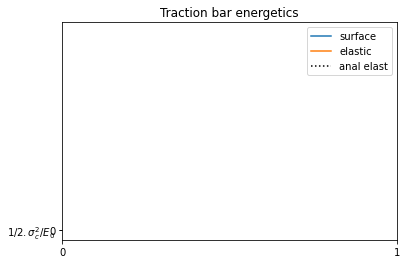

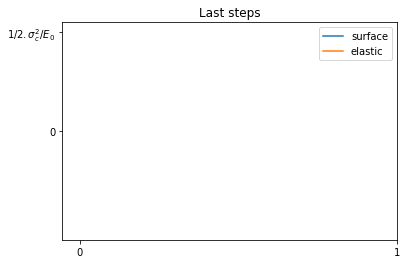

In [ ]:
plt.figure()
plt.plot(data.get('load'), data.get('surface'), label='surface')
plt.plot(data.get('load'), data.get('elastic'), label='elastic')
plt.plot(data.get('load'), [1./2. * t**2*Lx for t in data.get('load')], label='anal elast', ls=':', c='k')

plt.title('Traction bar energetics')
plt.legend()
plt.yticks([0, 1/20], [0, '$1/2.\sigma_c^2/E_0$'])
plt.xticks([0, 1], [0, 1])
plt.savefig("energetics.png")

# savings?
plt.figure()
plt.plot(data.get('load')[:-40], data.get('surface')[:-40], label='surface')
plt.plot(data.get('load')[:-40], data.get('elastic')[:-40], label='elastic')

plt.title('Last steps')
plt.legend()
plt.yticks([0, 1/20], [0, '$1/2.\sigma_c^2/E_0$'])
plt.xticks([0, 1], [0, 1])
plt.savefig("lastSteps.png")



plotter = pyvista.Plotter(
        title="Displacement",
        window_size=[1600, 600],
        shape=(1, 2),
    )

# _plt = plot_scalar(u_.sub(0), plotter, subplot=(0, 0))
_plt = plot_vector(u, plotter, subplot=(0, 1))
_plt.screenshot(f"displacement_MPI.png")


xvfb.start_xvfb(wait=0.05)
pyvista.OFF_SCREEN = True

plotter = pyvista.Plotter(
        title="Displacement",
        window_size=[1600, 600],
        shape=(1, 2),
    )

_plt = plot_scalar(alpha, plotter, subplot=(0, 0))
_plt.screenshot(f"alpha2.png")